In [291]:
import io, math, numpy, sys
import numpy as np
import scipy.optimize as opt
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [102]:
TEST_DATA_FILE="tracy_test_data.tab"
AREA_EARTH_SQ_KM=510100000.0 # 510.1 million km²
SQ_RADIAN_2_SQ_KM=AREA_EARTH_SQ_KM/(4.0*math.pi)

In [103]:
def xyz2angles(xyz):
    lon_radians = numpy.arctan2(xyz[1], xyz[0])
    lat_radians = numpy.arcsin(xyz[2])
    return np.array([lat_radians, lon_radians])

def angles2xyz(latlon_radians):
    xyz = [math.cos(latlon_radians[0]) * math.cos(latlon_radians[1]), math.cos(latlon_radians[0]) * math.sin(latlon_radians[1]), math.sin(latlon_radians[0])]
    return np.array(xyz)


In [104]:
def degrees_to_radians(angle):
    rad = math.pi * angle / 180.0
    return rad
np_degrees_to_radians = np.vectorize(degrees_to_radians)

def radians_to_degrees(rad):
    deg = 180.0 * rad / math.pi
    return deg
np_radians_to_degrees = np.vectorize(radians_to_degrees)

def xyz2latlon(xyz):
    latlon_radians = xyz2angles(xyz)
    lat_deg = radians_to_degrees(latlon_radians[0])
    lon_deg = radians_to_degrees(latlon_radians[1])
    return np.array([lat_deg, lon_deg])
    
def latlon2xyz(latlon_deg):
    xyz = angles2xyz([degrees_to_radians(latlon_deg[0]), degrees_to_radians(latlon_deg[1])])
    return xyz


In [105]:
# Assuming real input will look like: <latitude>\t<longitude>\t<tag>

def genTestData():
    with open(TEST_DATA_FILE, "w+") as g:
        Box=[ (30.15, -97.83), (30.35, -97.62)]
        DotParams = {
            "LowerLeft-Coarse": [ (Box[0][0], (Box[0][0] + Box[1][0])/2, 0.05)
                                 , (Box[0][1], (Box[0][1] + Box[1][1])/2, 0.05)  ],
            "Box-Fine": [ (Box[0][0], Box[1][0], 0.01)
                                 , (Box[0][1], Box[1][1], 0.01)  ],
            "UpperRight-Medium": [ ((Box[0][0] + Box[1][0])/2, Box[1][0], 0.03)
                                 , ((Box[0][1] + Box[1][1])/2, Box[1][1], 0.03)  ]
        }
        for tag in DotParams:
            latRange = DotParams[tag][0]
            lonRange = DotParams[tag][1]
            for lat in np.arange(*latRange):
                for lon in np.arange(*lonRange):
                    line = '\t'.join([ str(lat), str(lon), tag ]) + '\n'
                    g.write(line)
#           

In [106]:
genTestData()

In [107]:
def loadData(tracyDataPath):
    data = {}
    with open(tracyDataPath, "r") as f:
        for line in f:
            line = line.rstrip()
            A = line.split('\t')
            if len(A)==3:
                (lat, lon, tag) = A
                if tag not in data:
                    data[tag] = []
                data[tag].append( np.array([lat, lon], dtype=float) )
    return data

In [108]:
testData = loadData(TEST_DATA_FILE)

In [109]:
latlon2xyz([0.0,0.0])

array([1., 0., 0.])

In [251]:
# Some background

[-6.68884023e-16  4.00000000e+00 -4.00000000e+00]


,points,edge-points,ratio,N,inner
0,9,8,1.0,3,1
1,16,12,1.0,4,4
2,25,16,1.0,5,9
3,36,20,1.0,6,16
4,49,24,1.0,7,25
5,64,28,1.0,8,36


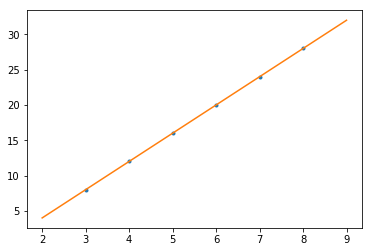

In [292]:
# Square grid:
#
#  For a square grid we find that the ratio of total points to 
#  hull points is ((4*math.sqrt(totalPoints))-4) = hullPoints
#
def takeALookAtSquareGrid():
    tableData = []
    xFit = []
    yFit = []
    for singleEdgeCount in range(3,9,1):
        allEdgeCount = 4 * (singleEdgeCount-2) + 4
        innerPoints = (singleEdgeCount - 2)**2
        totalPoints = allEdgeCount + innerPoints
        xFit.append(math.sqrt(totalPoints))
        yFit.append(allEdgeCount)
        tableData.append([totalPoints, allEdgeCount, (4*(math.sqrt(totalPoints)-1))/allEdgeCount, singleEdgeCount, innerPoints])
    f = np.polyfit(xFit, yFit, 2)
    print(f)
    
    p = np.poly1d(f)
    x2 = np.linspace(min(x)-1, max(x)+1, 100)
    plt.plot(x, y, '.', x2, p(x2), '-')
    
    df = pd.DataFrame(tableData, columns=['points', 'edge-points', 'ratio', 'N', 'inner'])
    return df
takeALookAtSquareGrid()

In [312]:
# even distribution over a circle
#
#    http://www.anderswallin.net/2009/05/uniform-random-points-in-a-circle-using-polar-coordinates/
#
#    Note: it is pretty clear that total number of points needs to be largish (900+)
#        before a circular dist starts to look even ... pretty good test data.
def takeALookAtCircularDist():
    tableData = []
    xFit = []
    yFit = []
    for i in range(30,41,1):
        x = []
        y = []
        totalPoints = i**2
        for j in range(totalPoints):
            r = math.sqrt(random.uniform(0.0, 1.0))
            theta = math.pi * (1.0  -  (2.0 * random.random()))
            x.append(r * math.cos(theta))
            y.append(r * math.sin(theta))
        # plt.plot(x, y, '.')
        
        points = np.array([np.array([x[i],y[i]]) for i in range(len(x))])
        hull = ConvexHull(points)
        hullPoints = len(hull.vertices)
        
        xFit.append(math.sqrt(totalPoints))
        yFit.append(hullPoints)
        
        tableData.append([totalPoints, hullPoints, math.pi * (math.sqrt(totalPoints)-1)/hullPoints, i ])
        
    f = np.polyfit(xFit, yFit, 2)
    print(f)
    df = pd.DataFrame(tableData, columns=['points', 'hull-points', 'ratio', 'N'])
    return df
takeALookAtCircularDist()

[ 1.78321678e-01 -1.21279720e+01  2.41615385e+02]


,points,hull-points,ratio,N
0,900,36,2.530727,30
1,961,40,2.356194,31
2,1024,34,2.864393,32
3,1089,36,2.792527,33
4,1156,41,2.528599,34
5,1225,35,3.051833,35
6,1296,29,3.791577,36
7,1369,41,2.758472,37
8,1444,36,3.228859,38
9,1521,40,2.984513,39


In [313]:
# So we see that for an arbitrary region, hull points versus total points alone
# is an insufficient metric for evaluating evenness of distribution.

3.049613511998549
3.0596001491245923
3.0785571077037273
3.101962776423119
-3.130968736261765
3.0971473726275156
3.038565995585421
-2.9827201518243465
-2.990640646923208
3.013916994949476
-3.114418954796082
-3.0800102984822284
3.0552123291067774
-3.1362112929453376
-3.0992721505562217
-3.022274592803887
-3.007933760438443
3.1139837479628536
-3.047613127574875
3.044515914600746
[33.54347826 17.54347826 19.54347826  4.54347826 19.54347826  9.54347826
 17.54347826 10.54347826 21.54347826  4.54347826 23.54347826 21.54347826
  1.54347826 31.54347826  7.54347826 29.54347826 38.54347826 16.54347826
 22.54347826  5.54347826 11.54347826 23.54347826 20.54347826]
[ 77.84032827  67.59151322  52.9968175   62.05660725  90.56788241
 116.53429796  93.31372962  57.8918796   74.18806613  63.3994042
  55.79861207  57.99584364  95.58660208  50.96197204  59.9709664
  68.68374712  93.92704982  78.34405277  66.51888326 117.13922189
  48.33486062  78.67817656  79.49498549]


,points,avg(ρ),min(ρ),max(ρ),σ(norm(ρ)),N
0,400,74.252848,48.334861,117.139222,0.733815,20


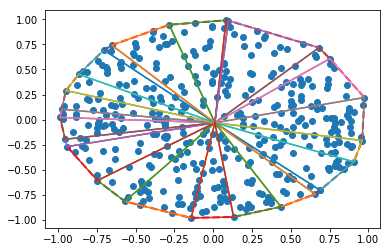

In [378]:
def takeALookAtHullPies():
    tableData = []
    xFit = []
    yFit = []
    for i in range(20,21,1):
        x = []
        y = []
        totalPoints = i**2
        for j in range(totalPoints):
            r = math.sqrt(random.uniform(0.0, 1.0))
            theta = random.uniform(-math.pi, math.pi)
            x.append(r * math.cos(theta))
            y.append(r * math.sin(theta))
        points = np.array([np.array([x[i],y[i]]) for i in range(len(x))])
        plt.plot(points[:,0], points[:,1], 'o')
        center = np.sum(points, axis=0)/totalPoints
        hull = ConvexHull(points)
        plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
        angles=[]
        areas=[]
        def nextIdx(vertidx):
            if vertidx + 1 == len(hull.vertices):
                return 0
            return vertidx + 1
        def vertPt(vertidx):
            return points[hull.vertices[vertidx]]
        #
        for vertidx in range(len(hull.vertices)):
            angle = math.atan2(vertPt(vertidx)[0] - center[0], vertPt(vertidx)[1] - center[1])
            angles.append(angle)
        # Now we need to sort the angles ... and rearrange the vertex indices
        angles = sorted([ (angles[vtxid], vtxid) for vtxid in range(len(hull.vertices)) ])
        
        for angleIdx in range(len(angles)):
            (angle, vertidx) = angles[angleIdx]
            nextAngleIdx = nextIdx(angleIdx)
            (nextAngle, nextVertIdx) = angles[nextAngleIdx]
            triangle = np.zeros((4,2))
            triangle[0] = center
            triangle[1] = vertPt(vertidx)
            triangle[2] = vertPt(nextVertIdx)
            triangle[3] = center            
            areas.append(shoeLace(triangle))
            plt.plot(triangle[:, 0], triangle[:, 1])
        #
        
        def triangleIndex(ptXY):
            ptAngle = math.atan2(ptXY[0] - center[0], ptXY[1] - center[1])
            # minus 1: We don't actually want to wrap around, + to - transition handled by default return
            for angleIdx in range(len(angles)-1):
                (angle, vertIdx) = angles[angleIdx]
                nextAngleIdx = nextIdx(angleIdx)
                (nextAngle, nextVertIdx) = angles[nextAngleIdx]
                if angle <= ptAngle and ptAngle < nextAngle:
                    return angleIdx
            print( ptAngle )
            return len(angles)-1
        #
        count = np.full(len(angles), 0.5 + 1.0/len(angles))
        for ptidx in range(totalPoints):
            triidx = triangleIndex(points[ptidx])
            count[triidx] = count[triidx] + 1
        densities = np.array([ count[i]/areas[i] for i in range(len(areas)) ])
        densityAvg = np.sum(densities)/len(densities)
        densityStdD = np.std((densities-min(densities))/(densityAvg-min(densities)))
        tableData.append([totalPoints, densityAvg, min(densities), max(densities), densityStdD, i])
        print(count)
        print(densities)
    df = pd.DataFrame(tableData, columns=['points', 'avg(ρ)', 'min(ρ)', 'max(ρ)', 'σ(norm(ρ))', 'N'])
    return df
#
takeALookAtHullPies()

In [377]:
# Now with a range of point sizes and no plots:

def takeALookAtHullPies2():
    tableData = []
    xFit = []
    yFit = []
    for i in range(20,40,1):
        x = []
        y = []
        totalPoints = i**2
        for j in range(totalPoints):
            r = math.sqrt(random.uniform(0.0, 1.0))
            theta = random.uniform(-math.pi, math.pi)
            x.append(r * math.cos(theta))
            y.append(r * math.sin(theta))
        points = np.array([np.array([x[i],y[i]]) for i in range(len(x))])
        center = np.sum(points, axis=0)/totalPoints
        hull = ConvexHull(points)
        angles=[]
        areas=[]
        def nextIdx(vertidx):
            if vertidx + 1 == len(hull.vertices):
                return 0
            return vertidx + 1
        def vertPt(vertidx):
            return points[hull.vertices[vertidx]]
        #
        for vertidx in range(len(hull.vertices)):
            angle = math.atan2(vertPt(vertidx)[0] - center[0], vertPt(vertidx)[1] - center[1])
            angles.append(angle)
        # Now we need to sort the angles ... and rearrange the vertex indices
        angles = sorted([ (angles[vtxid], vtxid) for vtxid in range(len(hull.vertices)) ])
        
        for angleIdx in range(len(angles)):
            (angle, vertidx) = angles[angleIdx]
            nextAngleIdx = nextIdx(angleIdx)
            (nextAngle, nextVertIdx) = angles[nextAngleIdx]
            triangle = np.zeros((3,2))
            triangle[0] = center
            triangle[1] = vertPt(vertidx)
            triangle[2] = vertPt(nextVertIdx)
            areas.append(shoeLace(triangle))
        #
        
        def triangleIndex(ptXY):
            ptAngle = math.atan2(ptXY[0] - center[0], ptXY[1] - center[1])
            # minus 1: We don't actually want to wrap around, + to - transition handled by default return
            for angleIdx in range(len(angles)-1):
                (angle, vertIdx) = angles[angleIdx]
                nextAngleIdx = nextIdx(angleIdx)
                (nextAngle, nextVertIdx) = angles[nextAngleIdx]
                if angle <= ptAngle and ptAngle < nextAngle:
                    return angleIdx
            return len(angles)-1
        #
        count = np.full(len(angles), 1.0)
        for ptidx in range(totalPoints):
            triidx = triangleIndex(points[ptidx])
            count[triidx] = count[triidx] + 1
        densities = np.array([ count[i]/areas[i] for i in range(len(areas)) ])
        densityAvg = np.sum(densities)/len(densities)
        densityStdD = np.std((densities-min(densities))/(densityAvg-min(densities)))
        tableData.append([totalPoints, len(angles), densityAvg, min(densities), max(densities), densityStdD, i])
    # rof
    
    df = pd.DataFrame(tableData, columns=['points', 'hull_points', 'avg(ρ)', 'min(ρ)', 'max(ρ)', 'σ(norm(ρ))', 'N'])
    return df
#
takeALookAtHullPies2()

,points,hull_points,avg(ρ),min(ρ),max(ρ),σ(norm(ρ)),N
0,400,25,74.700657,42.219297,140.995034,0.665840,20
1,441,23,85.208985,56.039445,162.120138,0.789431,21
2,484,26,89.012826,57.839392,147.638488,0.629482,22
3,529,29,104.681351,50.824464,236.584263,0.759310,23
4,576,28,104.933179,72.081093,170.753961,0.707303,24
5,625,33,117.284486,65.068607,242.436128,0.641078,25
6,676,29,117.897269,55.452768,185.442168,0.453513,26
7,729,33,123.687611,76.226280,166.402251,0.494599,27
8,784,30,140.378187,75.196453,257.032034,0.597836,28
9,841,28,148.100316,113.674687,201.828045,0.724977,29


In [375]:
# The normalized standard deviation of the distribution of points in the pie-slices of a convex hull 
# appears to be a reasonable measure of over-all distribution "evenness"
#
# The advantage of this approach is that a grid for testing the distribution does not
# need to be developed and it will work with arbitrary shapes of arbitrary orientation

In [389]:
# Second Best Friend:
#  Finds the distance of the second-closest point for every point in the dataset
#  Slower than HullPies, but very consistent
#  Gives a direct measure of the "grid" spacing and the consistency of this spacing.
def secondBestFriend(x, y):
    N = len(x)
    # Space for distances to nearest and second-nearest neighbors
    secondBestFriendDist = np.zeros((N, 2))
    
    def dist(iPt, jPt):
        return math.sqrt( (x[iPt]-x[jPt])**2 + (y[iPt]-y[jPt])**2 )

    for iPt in range(N):
        for jPt in range(iPt+1, N, 1):
            d = dist(iPt, jPt)
            if secondBestFriendDist[iPt][0] == 0.0:
                secondBestFriendDist[iPt,0] = d
            elif d < secondBestFriendDist[iPt,0]:
                secondBestFriendDist[iPt,1] = secondBestFriendDist[iPt,0]
                secondBestFriendDist[iPt,0] = d
            elif secondBestFriendDist[iPt][1] == 0.0:
                secondBestFriendDist[iPt,1] = d
            elif d < secondBestFriendDist[iPt,1]:
                secondBestFriendDist[iPt,1] = d

            if secondBestFriendDist[jPt][0] == 0.0:
                secondBestFriendDist[jPt,0] = d
            elif d < secondBestFriendDist[jPt,0]:
                secondBestFriendDist[jPt,1] = secondBestFriendDist[jPt,0]
                secondBestFriendDist[jPt,0] = d
            elif secondBestFriendDist[jPt][1] == 0.0:
                secondBestFriendDist[jPt,1] = d
            elif d < secondBestFriendDist[jPt,1]:
                secondBestFriendDist[jPt,1] = d
    #

    sbfMin = min(secondBestFriendDist[: ,1])
    sbfAvg = np.sum(secondBestFriendDist[: ,1], axis=0)/N
    sbfMax = max(secondBestFriendDist[: ,1])
    sbfStdD = np.std((secondBestFriendDist[: ,1]-sbfMin)/(sbfAvg-sbfMin))
    sbfMedian = np.median(secondBestFriendDist[: ,1], axis=0)
    
    return sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax)
#



In [390]:
def lookAtSecondBestFriend():
    tableData = []
    xFit = []
    yFit = []
    for i in range(15,24,1):
        x = []
        y = []
        totalPoints = i**2
        for j in range(totalPoints):
            r = math.sqrt(random.uniform(0.0, 1.0))
            theta = random.uniform(-math.pi, math.pi)
            x.append(r * math.cos(theta))
            y.append(r * math.sin(theta))
            
        sbfAvg, sbfStdD, (sbfMin, sbfMedian, sbfMax) = secondBestFriend(x, y)
        
        tableData.append([totalPoints, sbfAvg, sbfMedian, sbfMin, sbfMax, sbfStdD, i])
        
    df = pd.DataFrame(tableData, columns=['points', 'avg(SBF_dist)', 'median', 'min(dist)', 'max(dist)', 'σ(norm(dist))', 'N'])
    return df

lookAtSecondBestFriend()

,points,avg(SBF_dist),median,min(dist),max(dist),σ(norm(dist)),N
0,225,0.092891,0.095051,0.026991,0.205871,0.510988,15
1,256,0.083413,0.079707,0.010315,0.212650,0.508325,16
2,289,0.075942,0.077281,0.013095,0.172308,0.465650,17
3,324,0.077312,0.075140,0.017068,0.197785,0.486585,18
4,361,0.073435,0.071742,0.022398,0.175659,0.521709,19
5,400,0.069133,0.065099,0.016533,0.161409,0.484813,20
6,441,0.066482,0.066413,0.005814,0.145694,0.427331,21
7,484,0.061139,0.058837,0.011456,0.159449,0.466508,22
8,529,0.060446,0.058961,0.018242,0.145150,0.506282,23


In [ ]:
#

In [357]:
math.sqrt(300)

17.320508075688775

In [110]:
np.array(testData["LowerLeft-Coarse"])

array([[ 30.15, -97.83],
       [ 30.15, -97.78],
       [ 30.15, -97.73],
       [ 30.2 , -97.83],
       [ 30.2 , -97.78],
       [ 30.2 , -97.73],
       [ 30.25, -97.83],
       [ 30.25, -97.78],
       [ 30.25, -97.73]])

In [111]:
np.sum(np.array(testData["LowerLeft-Coarse"]),axis=0)

array([ 271.8 , -880.02])

In [ ]:
#  TODO: 1) Create function that generates evenly distributed random points within the unit
#           circle.
#        2) Test shoelace2 with increasing N
#        3) Is there an assymptote where shoelace area ==> <factor>*2*PI ?

In [218]:
def testKolmogorovSmirnov():
    M = np.random.uniform(0,1, 1000)
    print(stats.kstest(M, 'uniform'))
testKolmogorovSmirnov()

KstestResult(statistic=0.024276316529161845, pvalue=0.5974943904563339)


In [ ]:

def twentyFive():
    M = np.ones((5,5))
    for i in range(5):
        for j in range(5):
            L.append(np.array([i * 0.20, j * 0.20]))
    return np.array(L)
stats.kstest(twentyFive(), 'uniform')

In [209]:
def uniformity(XY):
    X = XY[:, 0:1]
    Y = XY[:, 1:2]
    X2 = MinMaxScaler().fit_transform(X)
    Y2 = MinMaxScaler().fit_transform(Y)
    XY2 = np.dstack((X2[:,0], Y2[:,0]))
    Rx = stats.kstest(X2, 'uniform')
    Ry = stats.kstest(Y2, 'uniform')
    Rxy = stats.kstest(XY2, 'uniform')
    print(Rx, Ry, Rxy)

In [204]:
uniformity(np.array(testData["Box-Fine"]))

KstestResult(statistic=1.0, pvalue=0.0) KstestResult(statistic=1.0, pvalue=0.0) KstestResult(statistic=1.0, pvalue=0.0)


In [242]:
# XY in [-π..π] (planar)
def polar(XY):
    meanVect = np.sum(XY, axis=0)/len(XY)
    def theta(xy):
        return math.atan2((xy - meanVect)[0], (xy - meanVect)[1])
    def radius(xy):
        return math.sqrt( (xy[0]-meanVect[0])**2 + (xy[1]-meanVect[1])**2 )
    return np.array([  np.array([ radius(XY[i]) , theta(XY[i]) ]) for i in range(len(XY)) ]) 

def radialDist(XY):
    buckets = np.zeros(8)
    RT = polar(XY)
    print(RT[:, 0:1]*(20000.0/math.pi))
    R8 = MinMaxScaler(feature_range=(0, 7)).fit_transform(RT[:, 0:1])
    for r in R8:
        if r > 8.0:
            print(r)
            r = 8.0
        r = int(math.floor(r))
        buckets[r] = buckets[r]+1
    return buckets



In [243]:
def normalize(X):
    return X/numpy.linalg.norm(X)

In [250]:
# STOPPED HERE
# Distribution does not seem correct ==> radius calc not correct?
#  For instance last bucket should always have at least 4 values (corners in test data) ... right?
for tag in testData:
    RR = np.array([np.array([math.pi * ll[0]/180.0, math.pi * ll[1]/180.0]) for ll in testData[tag]])
    print(tag, radialDist(RR))

[[7.85674201e+00]
 [5.55555556e+00]
 [7.85674201e+00]
 [5.55555556e+00]
 [1.41357986e-12]
 [5.55555556e+00]
 [7.85674201e+00]
 [5.55555556e+00]
 [7.85674201e+00]]
LowerLeft-Coarse [1. 0. 0. 0. 4. 0. 2. 2.]
[[1.57134840e+01]
 [1.49484712e+01]
 [1.42291650e+01]
 [1.35628396e+01]
 [1.29576709e+01]
 [1.24225999e+01]
 [1.19670329e+01]
 [1.16003406e+01]
 [1.13311545e+01]
 [1.11665285e+01]
 [1.11111111e+01]
 [1.11665285e+01]
 [1.13311545e+01]
 [1.16003406e+01]
 [1.19670329e+01]
 [1.24225999e+01]
 [1.29576709e+01]
 [1.35628396e+01]
 [1.42291650e+01]
 [1.49484712e+01]
 [1.57134840e+01]
 [1.49484712e+01]
 [1.41421356e+01]
 [1.33795495e+01]
 [1.26686158e+01]
 [1.20185043e+01]
 [1.14395890e+01]
 [1.09431753e+01]
 [1.05409255e+01]
 [1.02439383e+01]
 [1.00615390e+01]
 [1.00000000e+01]
 [1.00615390e+01]
 [1.02439383e+01]
 [1.05409255e+01]
 [1.09431753e+01]
 [1.14395890e+01]
 [1.20185043e+01]
 [1.26686158e+01]
 [1.33795495e+01]
 [1.41421356e+01]
 [1.49484712e+01]
 [1.42291650e+01]
 [1.33795495e+01]
 [

In [244]:
for tag in testData:
    XYZ = np.array([latlon2xyz(ll) for ll in testData[tag]])
    meanVec = np.sum(XYZ, axis=0)/len(latlonArray)
    XYZ00 = XYZ + (np.array([1.0,0.0,0.0]) - meanVec)
    XYZ00 = np.apply_along_axis(normalize, 0, XYZ00)
    RR = np.array([xyz2angles(xyz)  for xyz in XYZ00])
    print(tag, radialDist(RR))

[[5416.23655679]
 [6168.8550228 ]
 [6751.66653853]
 [1737.42665204]
 [   7.08360748]
 [1737.43816485]
 [6757.85059755]
 [6167.84521972]
 [5416.92582023]]
LowerLeft-Coarse [1. 2. 0. 0. 0. 2. 3. 1.]
[[7.29561496e-01]
 [6.55620030e-01]
 [5.81687541e-01]
 [5.07767107e-01]
 [4.33863905e-01]
 [3.59987356e-01]
 [2.86156603e-01]
 [2.12417378e-01]
 [1.38912411e-01]
 [6.64175065e-02]
 [2.15443687e-02]
 [8.63389608e-02]
 [1.59314742e-01]
 [2.32902564e-01]
 [3.06660722e-01]
 [3.80489024e-01]
 [4.54352319e-01]
 [5.28235100e-01]
 [6.02129468e-01]
 [6.76030974e-01]
 [7.49936924e-01]
 [7.30461596e-01]
 [6.56522435e-01]
 [5.82590886e-01]
 [5.08669428e-01]
 [4.34762224e-01]
 [3.60876843e-01]
 [2.87028644e-01]
 [2.13254241e-01]
 [1.39667537e-01]
 [6.68844403e-02]
 [1.93914855e-02]
 [8.49332654e-02]
 [1.58068185e-01]
 [2.31712832e-01]
 [3.05497374e-01]
 [3.79339041e-01]
 [4.53208949e-01]
 [5.27094397e-01]
 [6.00988924e-01]
 [6.74888899e-01]
 [7.48792124e-01]
 [7.31367005e-01]
 [6.57430732e-01]
 [5.8350085

In [112]:
def shoeLace(XY):
    accum = 0.0
    def nextIdx(ii):
        if ii+1 == len(XY):
            return 0
        return ii+1
    for i in range(len(XY)):
        accum += (XY[i][0]*XY[nextIdx(i)][1])
        accum -= (XY[i][1]*XY[nextIdx(i)][0])
    return abs(accum)

In [154]:
# XY in radians
def shoeLace2(XY):
    meanVect = np.sum(XY, axis=0)/len(XY)
    angles = [(math.atan2((XY[i] - meanVect)[0], (XY[i] - meanVect)[1]), i) for i in range(len(XY))]
    angles.sort()
    
    accum = 0.0
    def nextIdx(ii):
        if ii+1 == len(XY):
            return 0
        return ii+1
    def xyIdx(angleIdx):
        return angles[angleIdx][1]
    for i in range(len(XY)):
        accum += (XY[xyIdx(i)][0]*XY[xyIdx(nextIdx(i))][1])
        accum -= (XY[xyIdx(i)][1]*XY[xyIdx(nextIdx(i))][0])
    return abs(accum)

In [125]:
def crossAll(XYZ):
    if len(XYZ) < 2:
        return 1
    cross = np.cross(XYZ[0], XYZ[1])
    if len(XYZ) < 3:
        return cross
    for i in range(2, len(XYZ), 1):
        cross = np.cross(cross, XYZ[i])
    return cross

In [155]:
def areaMetrics(latlonArray):
    # shift to [0.0, 0.0]
    XYZ = np.array([latlon2xyz(ll) for ll in latlonArray])
    mean = np.sum(XYZ, axis=0)/len(latlonArray)
    ZZ = XYZ + (np.array([1.0,0.0,0.0]) - mean)
    RR = np.array([xyz2angles(xyz)/ numpy.linalg.norm(xyz) for xyz in ZZ])
    print(RR[0:2])
    area = shoeLace2(RR) * SQ_RADIAN_2_SQ_KM
    return area

In [156]:
areaMetrics(np.array(testData["Box-Fine"]))

[[-0.0015106  -0.00066877]
 [-0.00151037 -0.00068918]]


54.799373813710126

In [157]:
areaMetrics(np.array(testData["LowerLeft-Coarse"]))

[[-0.00075489 -0.0003331 ]
 [-0.00075433 -0.00043509]]


21.898775702503112

In [133]:
for tag in testData:
    XYZ = np.array([latlon2xyz(ll) for ll in testData[tag]])
    n = len(XYZ)    
    cross = crossAll(XYZ)
    magnitude = numpy.linalg.norm(cross)
    print((tag, 1.0/magnitude, 1.0/math.sqrt(magnitude), 
           1.0/(n*magnitude), 1.0/(n*math.sqrt(magnitude)), 
           math.pow(magnitude, 1.0/n)))

('LowerLeft-Coarse', 1325.199825424367, 36.40329415622117, 147.24442504715188, 4.044810461802353, 0.4498625573571733)
('Box-Fine', 6626.302656065775, 81.40210473977793, 15.025629605591327, 0.1845852715187708, 0.9802457900802849)
('UpperRight-Medium', 2210.9088207758105, 47.0203022191033, 138.18180129848815, 2.9387688886939562, 0.6179656325577657)


In [ ]:
# math.pow(magnitude, 1.0/n) -- this isn't going to work well with large numbers of points.  
# In general, this is a problem with cumulative cross product.  Overflow followed by underflow.

In [134]:
from sklearn.decomposition import PCA

In [140]:
def twoD_Gaussian(tup, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y) = tup
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()